# Spatial distribution of synapses along the length of the lamina cartridge
Use PCA to describe the distal-proximal distribution of synapse in *Megaphragma* lamina cartridges 

Authors: Deena Schefter, Nicholas Chua

In [1]:
# Imports

import numpy as np
import os.path
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#import plotly.express as px
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn import preprocessing
import scipy.stats
#import style
import json

from cx_analysis.utils import yymmdd_today
from cx_analysis.vis.fig_tools import subtype_cm
st_cm = subtype_cm()

In [2]:
# Formatting settings
save_figs = False
fig_path = os.path.expanduser(f'~/Figures/{yymmdd_today()}_')

plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle')


In [5]:
# Reading in pickle files

# File of all connectors with information about om, pre_type, etc
# links = pd.read_pickle("/Users/deenashefter/Downloads/200506_linkdf.pickle", compression='infer')
# df_links = pd.DataFrame(links)
# # display(df_links)

# # File of all connectors with their xyz coordinates
# cx_coords = pd.read_pickle("/Users/deenashefter/Downloads/200506_cxcoords.pickle", compression='infer')
# df_cx_coords = pd.DataFrame(cx_coords)
# display(df_cx_coords)
tp = '210809'
df_links = pd.read_pickle(f'Data/210809_linkdf.pickle')
df_cx_coords = pd.read_pickle(f'Data/210809_cxcoords.pickle')

In [6]:
# Preprocessing function, making dataframe of index cx_id and pre_om, pre_type, coordinates

def preprocessing():
    df_subset = df_links[['cx_id','pre_om','pre_type', 'post_om', 'post_type']]
    df_c = pd.merge(df_subset, df_cx_coords.reset_index(), left_on='cx_id',right_on='index').drop(['index'], axis=1)
    df_comp = df_c[df_c.post_om != 'UNKNOWN'].drop_duplicates()
    
    return df_comp
    
df_comp = preprocessing()

In [7]:
# Function to do PCA

def do_PCA(coordinates):
    pca = PCA(n_components=1)
    pca.fit(coordinates)
    transformed_all = pca.transform(coordinates)
    normalized = (transformed_all-np.min(transformed_all))/(np.max(transformed_all)-np.min(transformed_all))
    return normalized

In [8]:
# Function to flip orientation

def flip_PCA(dfd):
    pre_oms = dfd['pre_om'].unique()

    for o in pre_oms:
        df_oms = dfd.loc[dfd['pre_om'] == o]
        dfmin = df_oms.loc[df_oms['x'] == min(df_oms['x'])]
        dfmin = dfmin[['x','transformed_coords']]
        dfmax = df_oms.loc[df_oms['x'] == max(df_oms['x'])]
        dfmax = dfmax[['x','transformed_coords']]
        
        if dfmin['transformed_coords'].min() < dfmax['transformed_coords'].max():
            continue
        else:
            dfd.loc[dfd['pre_om'] == o, 'transformed_coords'] = 1 - dfd.loc[dfd['pre_om'] == o, 'transformed_coords']
    return dfd

In [9]:
# Makes df with transformed coords

dfd = df_comp.copy()
dfd["transformed_coords"] = np.nan
for om, rows in df_comp.groupby('pre_om'):
    coords = rows.loc[:, ['x', 'y', 'z']]
    normalized = do_PCA(coords)
    norm_list = [x[0] for x in normalized]
    dfd.loc[dfd["pre_om"]==om,"transformed_coords"] = norm_list


dfd_final = flip_PCA(dfd)

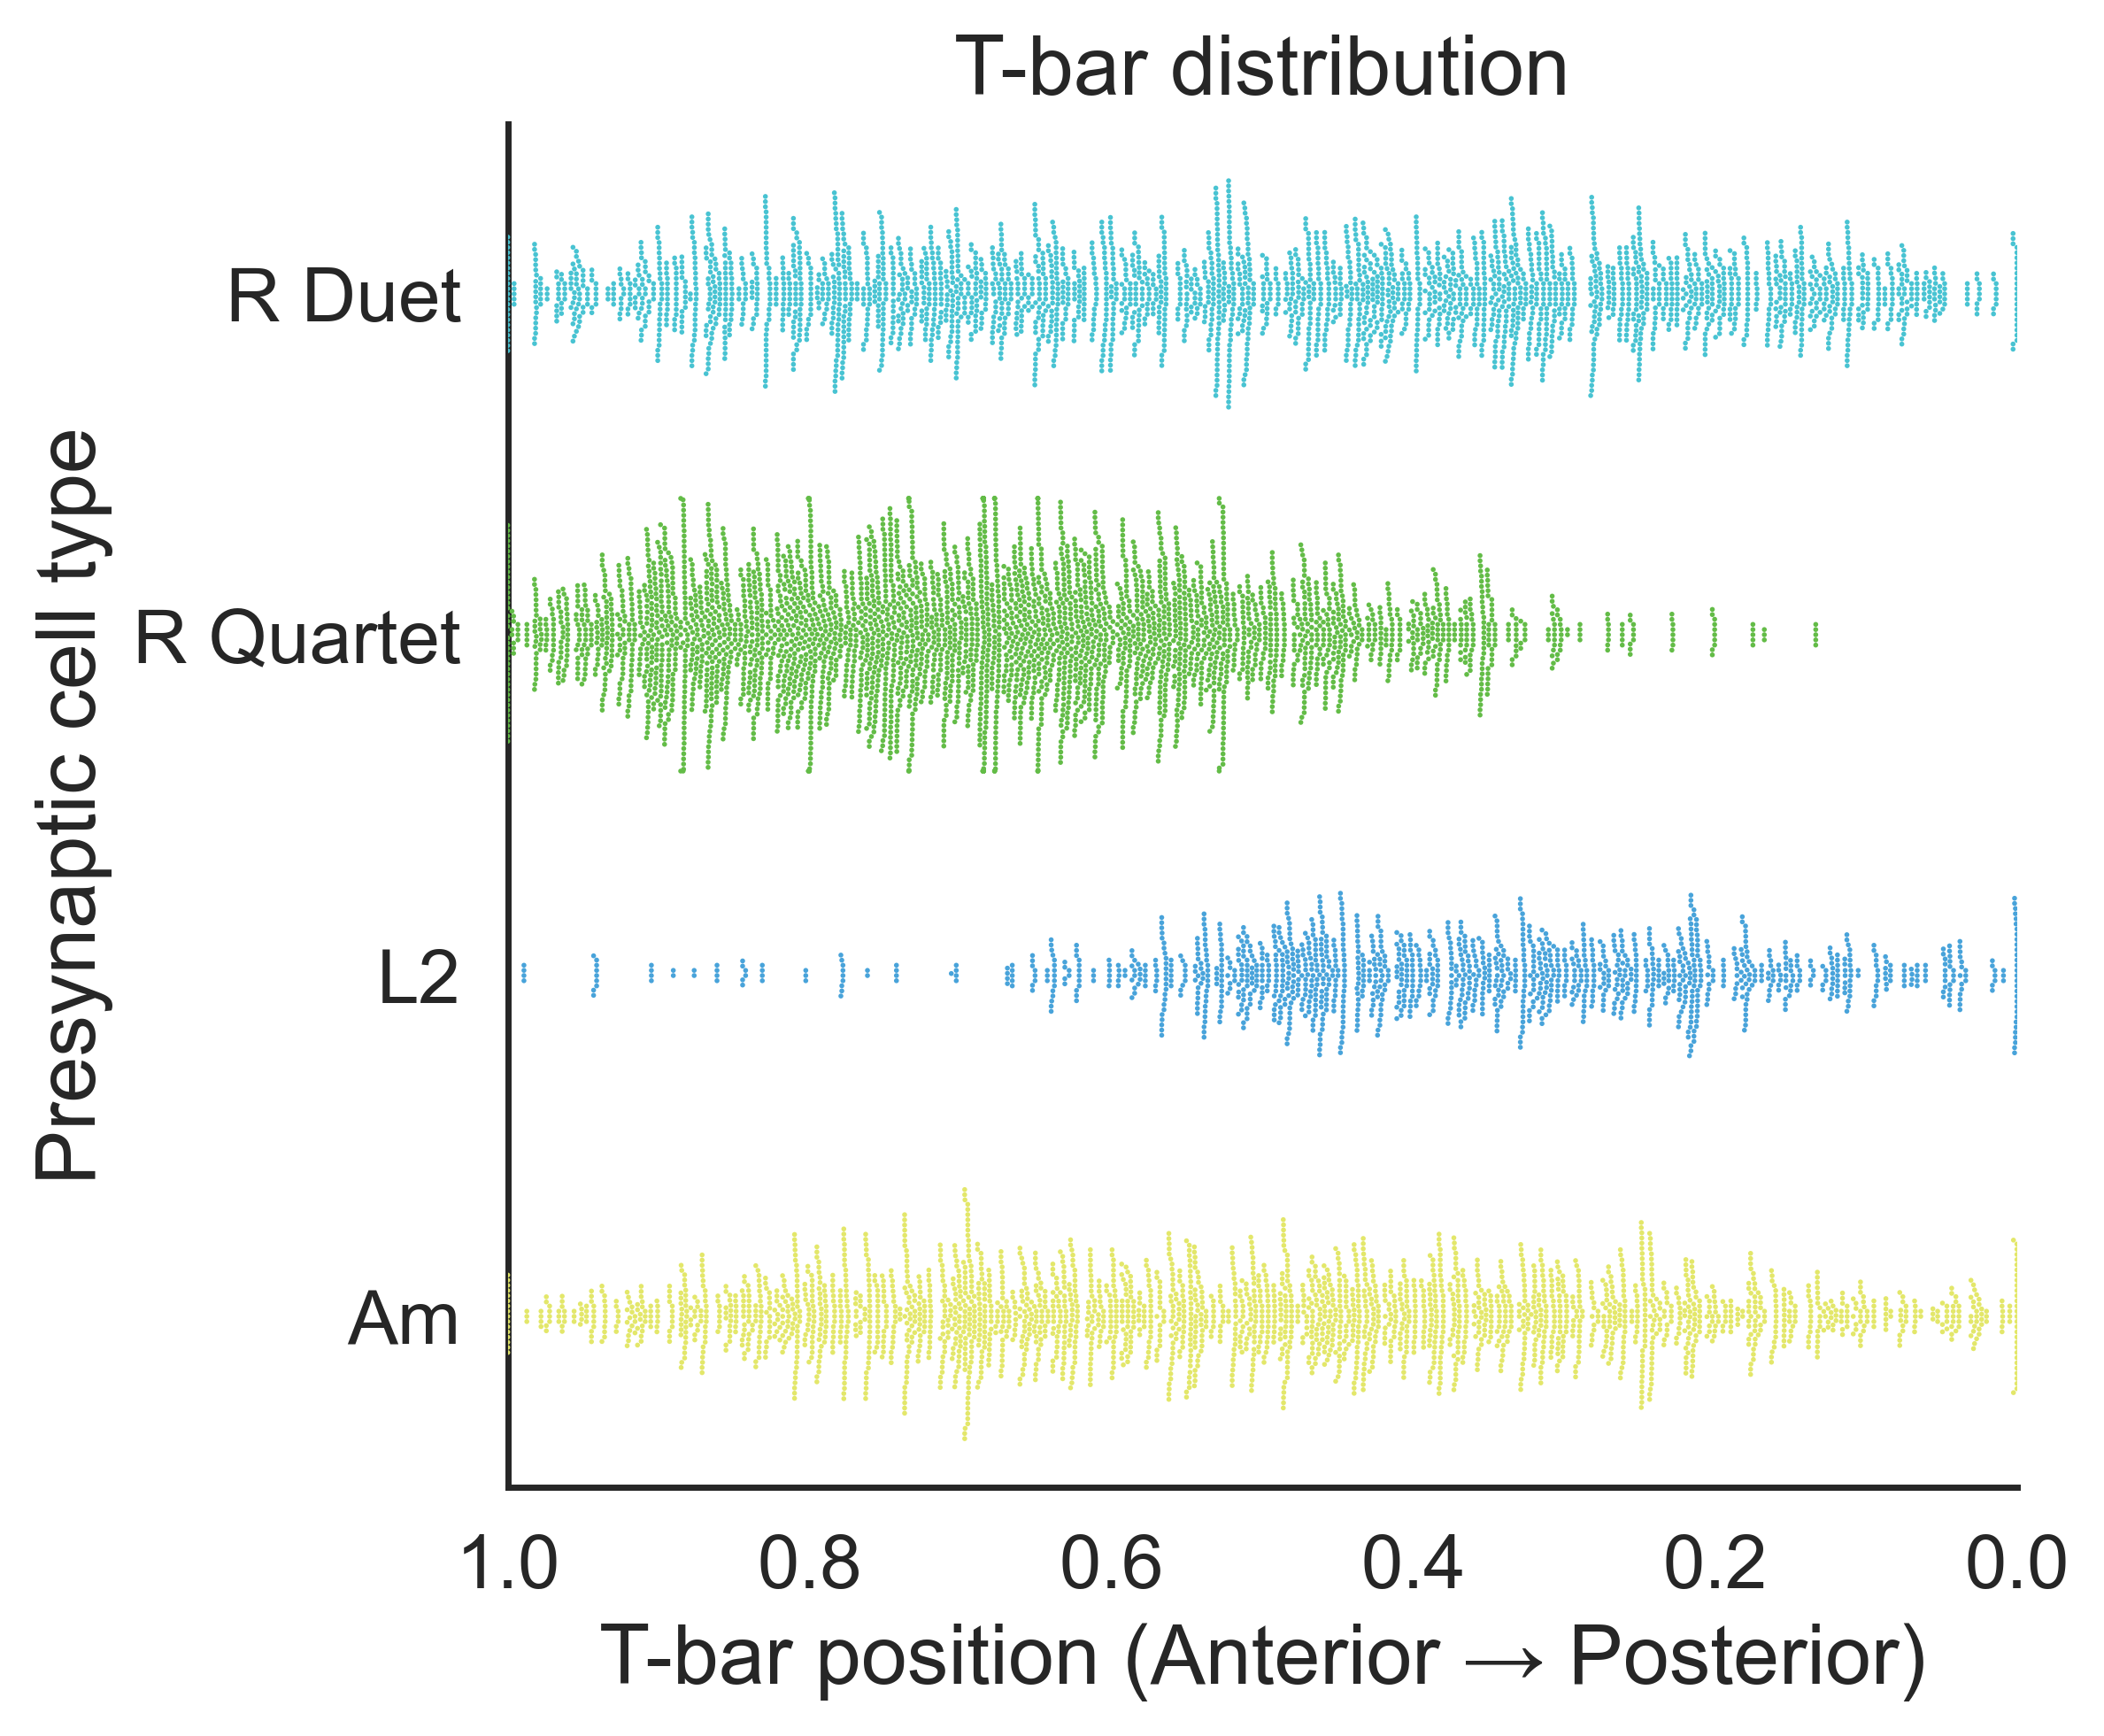

In [14]:
# Swarmplot

fig, ax = plt.subplots(1, figsize=[5.5, 5])

#L2 inputs        
data = dfd["transformed_coords"].round()
# df_postL2 = dfd.loc[dfd['post_type'] == 'LMC_2']
# df_postL2 = df_postL2.loc[(df_postL2['pre_type'] != 'LMC_4') & (df_postL2['pre_type'] != 'R7p')]
sns.swarmplot(x='transformed_coords', y='pre_type', data=dfd, palette=st_cm, size=1, order=['R_duet', 'R_quartet', 'LMC_2', 'centri'])
sns.set(font_scale=1.4)
ax.set_title('T-bar distribution')
sns.set(font_scale=1.4)
ax.set_xlabel('T-bar position (Anterior → Posterior)')
sns.set(font_scale=1.4)
ax.set_ylabel('Presynaptic cell type')
ax.set_xlim(1,0)
sns.set_style("white")

ax.set_yticklabels(['R Duet', 'R Quartet', 'L2', 'Am'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
if save_figs:
    fig.savefig(fig_path + 'tbar-length-dist.png')
    fig.savefig(fig_path + 'tbar-length-dist.svg')